## C3S.db Feature Engineering
### _Evaluation and optimization of the feature set to use in the prediction of CCS by ML on the data in the C3S.db (as of 2019/07/24)_
#### Dylan H. Ross

In [244]:
# setup...
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from numpy import abs, mean, std, sqrt, sum, histogram, cumsum, array, argsort, median
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import random

from matplotlib import rcParams

rcParams['font.size'] = 6



from C3SData.data import C3SD

# set an initial pRNG seed, increment for each individual trial  
pRNGs = 1234

### Introduction
In the initial characterization of the Combined CCS Database (`C3S.db`), only a subset of the 50 total molecular descriptions (MDs) were found to contribute strongly to variance in the CCS. First, we will test the performance of models trained on the full set of MDs compared to those trained on the set of identifiers identified previously. 

In [188]:
# define some utility functions for running and evaluating trials

def metrics(model, data):
    """
metrics
    description:
        computes a standard set of performance metrics using a trained model and dataset
            * training and test set R-squared (R2)
            * training and test set root mean squared error (RMSE)
            * training and test set mean absolute error (MAE)
            * cumulative error distribution at the <1, <3, <5, and <10% levels
              for training and test set (CE135A)
"""
    summary = {}
    for s in ['train', 'test']:
        if s == 'train':
            y = data.y_train_
            y_pred = model.predict(data.X_train_ss_)
        if s == 'test':
            y = data.y_test_
            y_pred = model.predict(data.X_test_ss_)
            
        # compute metrics
        abs_y_err = abs(y_pred - y)
        r2 = r2_score(y, y_pred)
        mae = mean(abs_y_err)
        mdae = median(abs_y_err)
        rmse = sqrt(mean_squared_error(y, y_pred))
        y_err_percent = 100. * abs_y_err / y
        cum_err = cumsum(histogram(y_err_percent, [_ for _ in range(101)])[0])
        cum_err = 100. * cum_err / sum(cum_err)
        ce1, ce3, ce5, ceA = cum_err[0], cum_err[2], cum_err[4], cum_err[9]
        summary[s] = {'R2': r2, 'MAE': mae, 'MDAE': mdae, 'RMSE': rmse, 'CE135A': [ce1, ce3, ce5, ceA]}
    return summary
        

def n_trials(model, mqn_indices, N, pRNGs, p_grid=None):
    """
n_trials
    description:
        runs N trials training and evaluating a specified model with a specified dataset, each trial 
        using a different pRNG seed to establish different data splits. Returns the metrics from each trial.
"""
    trial_metrics = []
    for i in range(N):
        print('trial {:3d} of {:3d} ...'.format(i + 1, N), end=' ')
        pRNGs += 1
        data = C3SD('C3S.db', seed=pRNGs)
        data.featurize(mqn_indices=mqn_indices)
        data.train_test_split('ccs')
        data.center_and_scale()
        
        # if a parameter grid is provided, perform hyperparameter optimization, otherwise simply fit the
        # data with the model directly
        if p_grid:
            gs = GridSearchCV(model, param_grid=p_grid, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')
            gs.fit(data.X_train_ss_, data.y_train_)
            model_best = gs.best_estimator_
            print('best parameters:', gs.best_params_)
        else:
            model_best = model.fit(data.X_train_ss_, data.y_train_)
        
        trial_metrics.append(metrics(model_best, data))
    
        print('ok')
    return trial_metrics


def summary_figure(summary, r2_range=[0.95, 1.], save=None):
    """
summary_figure
    description:
        produces a summary figure displaying the results from a trial
    parameters:
        [r2_range (list(float))] -- upper and lower bounds of R-squared y axis [optional, default=[0.95, 1.]]
        [save (None or str)] -- if a filename is provided, save the figure (optional, default=None)
"""
    
    fig = plt.figure(figsize=(7, 3))
    gs = GridSpec(1, 3, figure=fig, width_ratios=[1, 3, 5])
    
    # R-squared
    ax1 = fig.add_subplot(gs[0])
    rsq_trn, rsq_trn_sd = mean([_['train']['R2'] for _ in summary]), std([_['train']['R2'] for _ in summary])
    rsq_tst, rsq_tst_sd = mean([_['test']['R2'] for _ in summary]), std([_['test']['R2'] for _ in summary])
    ax1.bar([0.87, 1.13], [rsq_trn, rsq_tst], color=['b', 'r'], yerr=[rsq_trn_sd, rsq_tst_sd], width=0.25)
    for d in ['top', 'right']:
        ax1.spines[d].set_visible(False)
    ax1.set_xticks([])
    ax1.set_ylabel(r'R$^2$')
    ax1.set_ylim(r2_range)
    
    # MAE, MDAE and RMSE
    ax2 = fig.add_subplot(gs[1])
    mae_trn, mae_trn_sd = mean([_['train']['MAE'] for _ in summary]), std([_['train']['MAE'] for _ in summary])
    mae_tst, mae_tst_sd = mean([_['test']['MAE'] for _ in summary]), std([_['test']['MAE'] for _ in summary])
    mdae_trn, mdae_trn_sd = mean([_['train']['MDAE'] for _ in summary]), std([_['train']['MDAE'] for _ in summary])
    mdae_tst, mdae_tst_sd = mean([_['test']['MDAE'] for _ in summary]), std([_['test']['MDAE'] for _ in summary])
    mse_trn, mse_trn_sd = mean([_['train']['RMSE'] for _ in summary]), std([_['train']['RMSE'] for _ in summary])
    mse_tst, mse_tst_sd = mean([_['test']['RMSE'] for _ in summary]), std([_['test']['RMSE'] for _ in summary])
    ax2.bar([0.87, 1.13], [mae_trn, mae_tst], color=['b', 'r'], yerr=[mae_trn_sd, mae_tst_sd], width=0.25)
    ax2.bar([1.87, 2.13], [mdae_trn, mdae_tst], color=['b', 'r'], yerr=[mae_trn_sd, mae_tst_sd], width=0.25)
    ax2.bar([2.87, 3.13], [mse_trn, mse_tst], color=['b', 'r'], yerr=[mse_trn_sd, mse_tst_sd], width=0.25)
    for d in ['top', 'right']:
        ax2.spines[d].set_visible(False)
    ax2.set_xticks([1, 2, 3])
    ax2.set_xticklabels(['MAE', 'MDAE', 'RMSE'])
    ax2.set_ylabel(r'CCS (Å$^2$)')
    
    # CE135A
    ax3 = fig.add_subplot(gs[2])
    x1 = [_ - 0.13 for _ in range(1, 5)]
    y1 = [100. * mean([_['train']['CE135A'][i] for _ in summary]) for i in range(4)]
    e1 = [100. * std([_['train']['CE135A'][i] for _ in summary]) for i in range(4)]
    x2 = [_ + 0.13 for _ in range(1, 5)]
    y2 = [100. * mean([_['test']['CE135A'][i] for _ in summary]) for i in range(4)]
    e2 = [100. * std([_['test']['CE135A'][i] for _ in summary]) for i in range(4)]
    
    ax3.bar(x1, y1, color='b', yerr=e1, width=0.25)
    ax3.bar(x2, y2, color='r', yerr=e2, width=0.25)
    
    for d in ['top', 'right']:
        ax3.spines[d].set_visible(False)
    ax3.set_xlabel('pred. error (%)')
    ax3.set_xticks([1, 2, 3, 4])
    ax3.set_xticklabels(['<1', '<3', '<5', '<10'])
    ax3.set_ylabel('proportion (%)')

    
    plt.tight_layout()
    plt.show()

To test these two sets of MDs, examine three distinct types of ML model:
* linear, without regularization (`LinearRegression`)
* SVR with rbf kernel (`SVR`)
* random forest (`RandomForestRegression`)

In [170]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

mqn_subset = [0, 9, 11, 12, 13, 15, 18, 19, 20, 21, 22, 25, 26, 27, 30]
# perform 20 trials each
N = 20

# linear regression
print('\nlinear, all MDs')
linear_all = n_trials(LinearRegression(), 'all', N, pRNGs)
pRNGs += N
print('\nlinear, MD subset')
linear_sub = n_trials(LinearRegression(), mqn_subset, N, pRNGs)

# SVR with rbf kernel
pRNGs += N
svr_p_grid = {
    'C': [0.1, 0.3, 0.5, 1, 3, 5, 10],
    'gamma': [0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1]
}
print('\nSVR, all MDs')
svr_all = n_trials(SVR(cache_size=1024, tol=5e-4), 'all', N, pRNGs, p_grid=svr_p_grid)
pRNGs += N
print('\nSVR, MD subset')
svr_sub = n_trials(SVR(cache_size=1024, tol=5e-4), mqn_subset, N, pRNGs, p_grid=svr_p_grid)

# random forest
pRNGs += N
forest_p_grid = {
    'max_depth': [2, 4, 6, 8],
    'bootstrap': [True, False], 
    'min_samples_leaf': [0.256, 0.128, 0.064, 0.032, 0.016, 0.008, 0.004, 0.002, 0.001],
    'n_estimators': [8, 16, 32, 64, 128]
}
print('\nrandom forest, all MDs')
forest_all = n_trials(RandomForestRegressor(), 'all', N, pRNGs, p_grid=forest_p_grid)
pRNGs += N
print('\nrandom forest, MD subset')
forest_sub = n_trials(RandomForestRegressor(), mqn_subset, N, pRNGs, p_grid=forest_p_grid)



linear, all MDs
trial   1 of  20 ... ok
trial   2 of  20 ... ok
trial   3 of  20 ... ok
trial   4 of  20 ... ok
trial   5 of  20 ... ok
trial   6 of  20 ... ok
trial   7 of  20 ... ok
trial   8 of  20 ... ok
trial   9 of  20 ... ok
trial  10 of  20 ... ok
trial  11 of  20 ... ok
trial  12 of  20 ... ok
trial  13 of  20 ... ok
trial  14 of  20 ... ok
trial  15 of  20 ... ok
trial  16 of  20 ... ok
trial  17 of  20 ... ok
trial  18 of  20 ... ok
trial  19 of  20 ... ok
trial  20 of  20 ... ok

linear, MD subset
trial   1 of  20 ... ok
trial   2 of  20 ... ok
trial   3 of  20 ... ok
trial   4 of  20 ... ok
trial   5 of  20 ... ok
trial   6 of  20 ... ok
trial   7 of  20 ... ok
trial   8 of  20 ... ok
trial   9 of  20 ... ok
trial  10 of  20 ... ok
trial  11 of  20 ... ok
trial  12 of  20 ... ok
trial  13 of  20 ... ok
trial  14 of  20 ... ok
trial  15 of  20 ... ok
trial  16 of  20 ... ok
trial  17 of  20 ... ok
trial  18 of  20 ... ok
trial  19 of  20 ... ok
trial  20 of  20 ... ok

SVR

KeyboardInterrupt: 

### LinearRegression

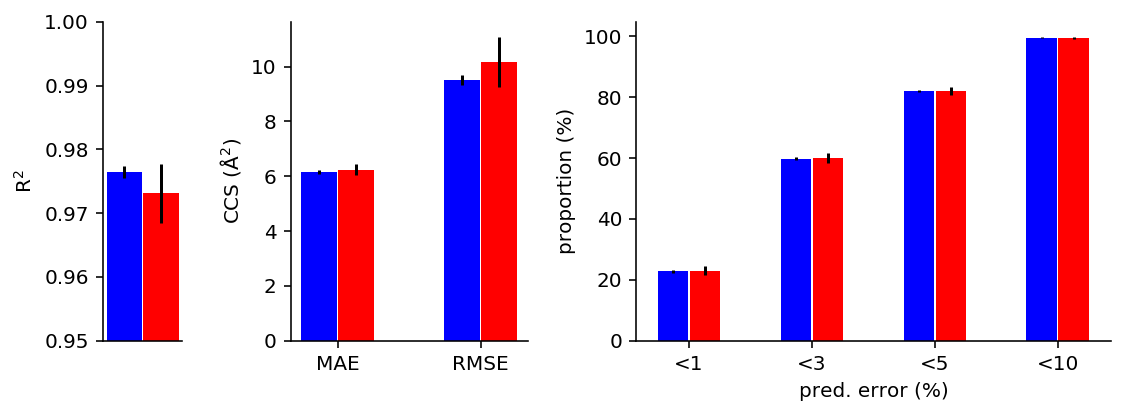

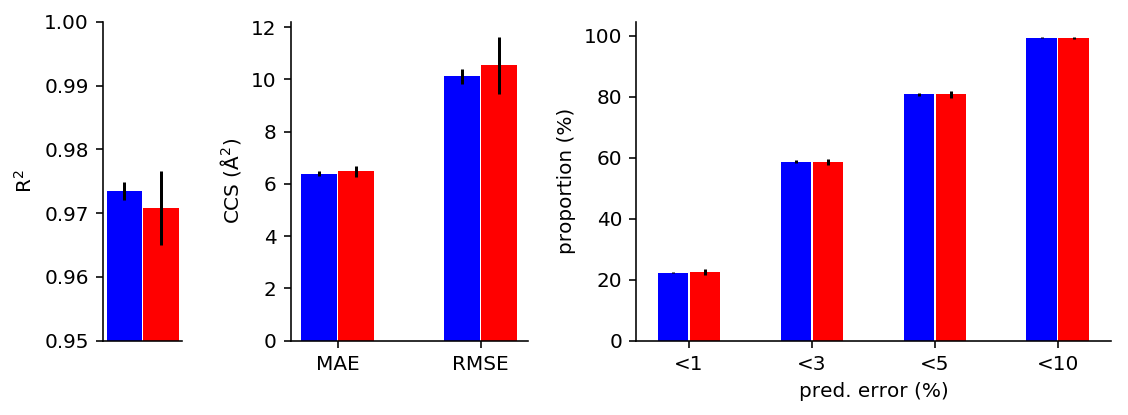

In [4]:
summary_figure(linear_all)
summary_figure(linear_sub)

### SVR

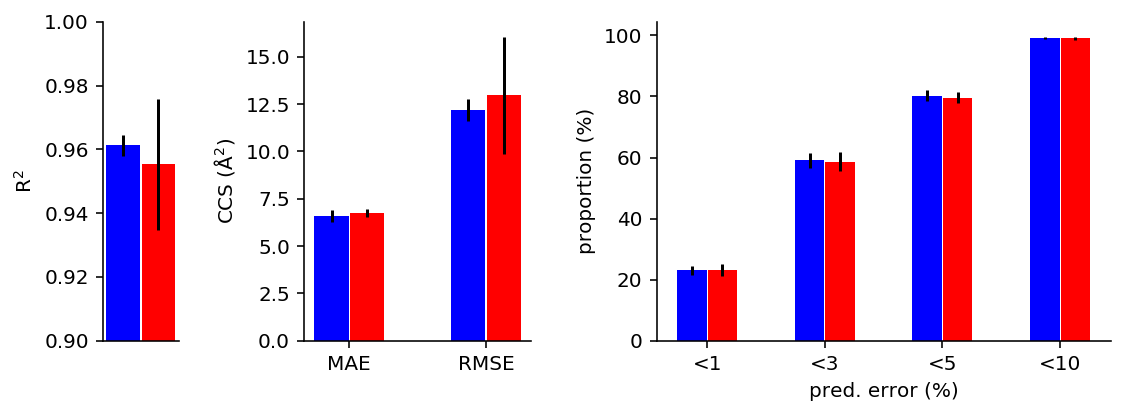

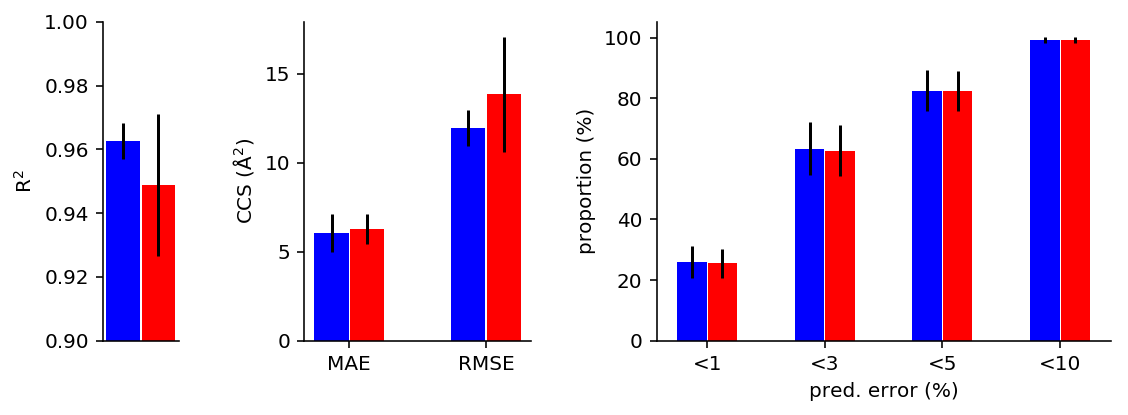

In [8]:
summary_figure(svr_all)
summary_figure(svr_sub)

### RandomForestRegressor

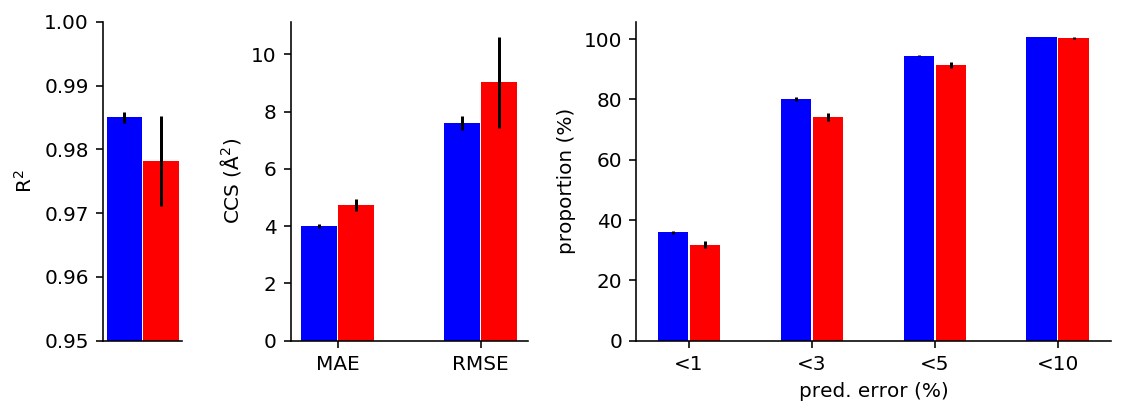

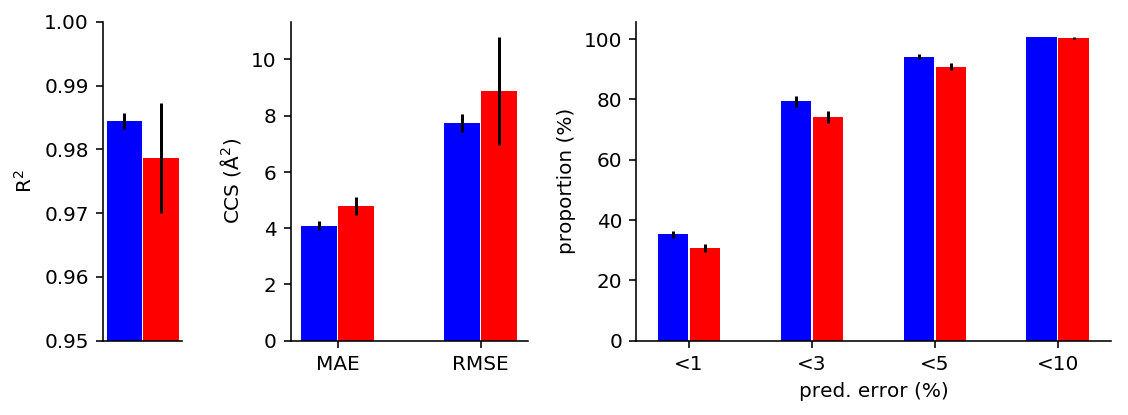

In [6]:
summary_figure(forest_all)
summary_figure(forest_sub)

### Results
Across all three types of models tested, training on the reduced feature set relative to the full did not cause a significant lapse in model performance, as assessed by a variety of different performance metrics. This result shows that the manually generated list of important MDs contains sufficient information to produce high-confidence predictions using a variety of ML models. Interestingly, the performance of the `SVR` models was significantly lower than both the `LinearRegression` and `RandomForestRegressor` models in all metrics. 

### Untargeted Feature Selection
Although there were no significant performance losses associated with use of a manually selected, greatly reduced feature set, there may be an even smaller feature set that still contains most of the relevant information required to make predictions with high accuracy. The best way of finding this feature set in a an unbiased fashion is to perform multiple trials in which the size of the feature set is reduced by a stochastic process and the relative importance of individual features is reflected by the relative frequency with which they are retained. For this we will set a threshold performance benchmark relative to the full dataset (using RMSE as our performance metric), after which we will restart the process (start with a 10% drop in average performance, or should it be based on the uncertainty in the performance, _i.e._ 2 SD greater than the average RMSE in the test set?). At each step, a feature is randomly removed and the performance is checked again. First, we will record the average performance as a function of number of features, then look at the frequency of retained features. 



In [25]:
def feature_trials(pRNGs, model, p_grid=None, N=5):
    """
feature_trials
    description:
        perform a full round of training a model (with N replicates), recording its average performance, then
        iteratively remove random features and retrain, until the average RMSE is > 2SD above that of the full
        feature set. Record the features that are present at each step.
""" 
    # feature frequency
    feat_freq = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                 1, 1]
    # perfomance as a function of n_features
    perf_n_feat = []
    
    # first, train the model N times and get the performance metrics
    start_mets = n_trials(model, 'all', N, pRNGs, p_grid=p_grid)
    rmse_av = mean([_['test']['RMSE'] for _ in start_mets])
    rmse_sd = std([_['test']['RMSE'] for _ in start_mets])
    perf_n_feat.append([42, rmse_av])
    
    # performance loss threshold: RMSE_new > RMSE_start + 2SD
    threshold = rmse_av + 2. * rmse_sd
    
    pRNGs += N
    random.seed(pRNGs)
    
    # remove a random feature
    print('removed a feature')
    all_mqns = [_ for _ in range(0, 42)]
    rem = random.choice(all_mqns)
    new_indices = [_ for _ in all_mqns if _ != rem]
    new_mets = n_trials(model, new_indices, 1, pRNGs, p_grid=p_grid)
    rmse_av_new = mean([_['test']['RMSE'] for _ in new_mets])
    pRNGs += N
    # continue the process until error increases by too much
    while rmse_av_new <= threshold:
        # adjust compute and store trial metrics
        for i in new_indices:
            feat_freq[i] += 1
        perf_n_feat.append([len(new_indices), rmse_av_new])
        # run another trial
        print('removed a feature')
        rem = random.choice(new_indices)
        new_indices = [_ for _ in new_indices if _ != rem]
        new_mets = n_trials(model, new_indices, 1, pRNGs, p_grid=p_grid)
        rmse_av_new = mean([_['test']['RMSE'] for _ in new_mets])
        pRNGs += 42
    
    return perf_n_feat, feat_freq

In [26]:
feature_trial_data = []
for i in range(500):
    print('--> BIG TRIAL', i + 1, '...')
    feature_trial_data.append(feature_trials(i + 100, LinearRegression(n_jobs=-1)))

--> BIG TRIAL 1 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
tr

trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 7 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ...

trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 16 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 17 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 

trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a 

trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 57 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 58 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
tria

trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 75 ...
trial   1 of   5 ... ok
trial  

trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 81 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 82 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
tria

trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a 

trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 125 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 126 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   

trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 148 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 149 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   

trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 177 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 178 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
tr

trial   1 of   1 ... ok
--> BIG TRIAL 193 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 194 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
tr

trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 208 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 209 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed 

trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a 

trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 222 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 .

trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 231 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 232 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
tr

trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 242 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 .

trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 253 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 .

trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 259 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 260 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
tr

trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 273 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 274 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
tr

trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 298 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok


trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 304 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 .

trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 318 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 .

trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 338 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 .

trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 354 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 .

trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 366 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial 

trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 379 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 .

trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 385 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 386 ...
trial   1 of  

trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 407 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 .

trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 428 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 .

trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 439 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 .

trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 458 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 459 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 460 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 

trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
--> BIG TRIAL 481 ...
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 .

trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a feature
trial   1 of   1 ... ok
removed a 

In [27]:
feature_trial_data

[([[42, 10.030582873733621],
   [41, 8.870870830083893],
   [40, 9.08664463742298],
   [39, 8.579282083755727],
   [38, 12.357497785164432],
   [37, 10.386494527110063],
   [36, 9.736794933654812],
   [35, 11.415254982009213],
   [34, 9.036808308255871],
   [33, 9.287525818542083],
   [32, 9.837661857048348],
   [31, 10.04999747916477],
   [30, 8.640398879181635],
   [29, 8.925867327290709],
   [28, 10.101094341209055],
   [27, 10.642278255994635],
   [26, 11.02880934613004],
   [25, 10.854166731838742],
   [24, 11.951387095518367],
   [23, 10.00645331453645],
   [22, 10.25836544592193],
   [21, 10.625971158186898],
   [20, 11.563532187980126],
   [19, 9.452651350233106],
   [18, 11.58361310981893],
   [17, 10.668109479599064],
   [16, 9.944924668762786]],
  [5,
   27,
   27,
   27,
   16,
   15,
   4,
   12,
   27,
   27,
   20,
   27,
   10,
   27,
   26,
   27,
   27,
   19,
   18,
   27,
   9,
   6,
   2,
   27,
   23,
   8,
   21,
   27,
   27,
   11,
   24,
   27,
   17,
   13,
 

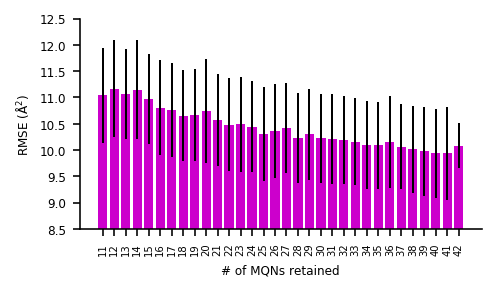

In [299]:
# plot average model performance as a function of # of MQNs retained
fig = plt.figure(figsize=(3.5, 2))
ax = fig.add_subplot(111)

n_v_rmse = []
for d in feature_trial_data:
    for n_, r_ in d[0]:
        n_v_rmse.append([n_, r_])
    

m = [mean([r for n, r in n_v_rmse if n == i]) for i in range(11, 43)]
s = [std([r for n, r in n_v_rmse if n == i]) for i in range(11, 43)]
ax.bar([_ for _ in range(11, 43)], m, yerr=s, color='#CC00CC', error_kw={'elinewidth': 1})
    

ax.set_xlabel('# of MQNs retained')
ax.set_xticks([_ for _ in range(11, 43)])
ax.set_xticklabels([_ for _ in range(11, 43)], rotation='vertical', fontsize=5)
ax.set_ylabel(r'RMSE (Å$^2$)')
ax.set_ylim([8.5, 12.5])

for d in ['top', 'right']:
    ax.spines[d].set_visible(False)
    
plt.tight_layout()

plt.savefig('RMSE_v_MQNs_retained.png', dpi=300, bbox_inches='tight')

plt.show()


In [71]:
feat_freq = array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                   1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                   1, 1])

for t in feature_trial_data:
    feat_freq += array(t[1])

feat_freq

array([5452, 5556, 5230, 5574, 5313, 5479, 5470, 5336, 5559, 5469, 5226,
       5707, 5295, 5580, 5221, 5553, 5527, 5357, 5441, 5432, 5323, 5276,
       5143, 5271, 5459, 5237, 5513, 5342, 5396, 5580, 5172, 5031, 5461,
       5341, 5308, 5665, 5359, 5209, 5477, 5201, 5301, 5319])

In [51]:
feat_freq / max(feat_freq)

array([0.95531803, 0.97354127, 0.91641843, 0.97669529, 0.93096198,
       0.96004906, 0.95847205, 0.93499211, 0.97406694, 0.95829683,
       0.91571754, 1.        , 0.92780796, 0.97774663, 0.91484142,
       0.97301559, 0.96845979, 0.93867181, 0.95339057, 0.95181356,
       0.93271421, 0.92447871, 0.901174  , 0.92360259, 0.95654459,
       0.917645  , 0.96600666, 0.93604346, 0.94550552, 0.97774663,
       0.90625548, 0.88154897, 0.95689504, 0.93586823, 0.93008586,
       0.99264062, 0.93902225, 0.91273874, 0.95969862, 0.91133695,
       0.9288593 , 0.93201332])

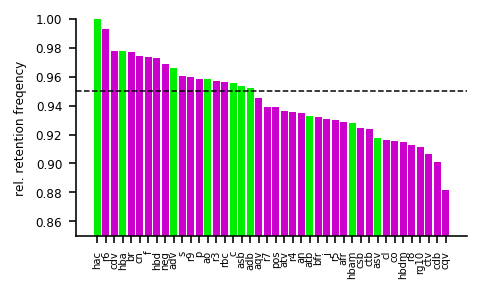

In [298]:
# convert the indices into the actual MD identifiers
mqn_id = [
    'c', 'f', 'cl', 'br',
    'i', 's', 'p', 'an',
    'cn', 'ao', 'co', 'hac',
    'hbam', 'hba', 'hbdm',
    'hbd', 'neg', 'pos',
    'asb', 'adb', 'atb', 'csb',
    'cdb', 'ctb', 'rbc',
    'asv', 'adv', 'atv', 'aqv',
    'cdv', 'ctv', 'cqv', 'r3',
    'r4', 'r5', 'r6', 'r7',
    'r8', 'r9', 'rg10', 'afr',
    'bfr'
]

# plot the relative frequencies of different MQNs being retained over the course of the whole experiment
fig = plt.figure(figsize=(3.5, 2))
ax = fig.add_subplot(111)
i = argsort(feat_freq)[::-1]
ffsorted = [feat_freq[_] for _ in i]

ms1 = [11, 12, 0, 9, 18, 25, 19, 20, 26, 13]
special_colors = []
for idx in i:
    if idx in ms1:
        special_colors.append('#00EE00')
    else:
        special_colors.append('#CC00CC')

ax.bar([_ for _ in range(1, 43)], ffsorted / max(feat_freq), color=special_colors)
ax.axhline(0.95, ls='--', c='k', lw=0.75)
ax.set_ylim([0.85, 1])
ax.set_xticks([_ for _ in range(1, 43)])
for d in ['top', 'right']:
    ax.spines[d].set_visible(False)
xlabs = array([mqn_id[_] for _ in i])
ax.set_xticklabels(xlabs, rotation='vertical', fontsize=5)
ax.set_ylabel('rel. retention freqency')



plt.savefig('feature_retention_freq.png', dpi=300, bbox_inches='tight')

plt.show()


In [264]:
# feature indices for features with >= 0.95 relative retention frequency
fsel_keepers = []
for idx in argsort(feat_freq)[::-1]:
    if feat_freq[idx] / max(feat_freq) >= 0.95:
        fsel_keepers.append(idx)
        
print(fsel_keepers)

[11, 35, 29, 13, 3, 8, 1, 15, 16, 26, 5, 38, 6, 9, 32, 24, 0, 18, 19]


### Value of Single MQNs
Perform an experiment where models are trained with no MQNs, then a single MQN and their performance is compared, normalized to the performance of the models trained without any MQNs.
First, establish the baseline performance of the models trained without any MQNs.

In [125]:
# perform 5 trials each
N = 5

# linear regression
print('\nlinear, no MQNs')
linear_nomqn = n_trials(LinearRegression(), [], N, pRNGs)

# SVR with rbf kernel
pRNGs += N
svr_p_grid = {
    'C': [0.1, 0.3, 0.5, 1, 3, 5, 10],
    'gamma': [0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1]
}
print('\nSVR, no MQNs')
svr_nomqn = n_trials(SVR(cache_size=1024, tol=5e-4), [], N, pRNGs, p_grid=svr_p_grid)

# random forest
pRNGs += N
forest_p_grid = {
    'max_depth': [2, 4, 6, 8],
    'bootstrap': [True, False], 
    'min_samples_leaf': [0.256, 0.128, 0.064, 0.032, 0.016, 0.008, 0.004, 0.002, 0.001],
    'n_estimators': [8, 16, 32, 64, 128]
}
print('\nrandom forest, no MQNs')
forest_nomqn = n_trials(RandomForestRegressor(), [], N, pRNGs, p_grid=forest_p_grid)



linear, no MQNs
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok

SVR, no MQNs
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


ok
trial   5 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


ok

random forest, no MQNs
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


ok


### LinearRegression - all MDs _vs._ MD subset _vs._ no MQNs

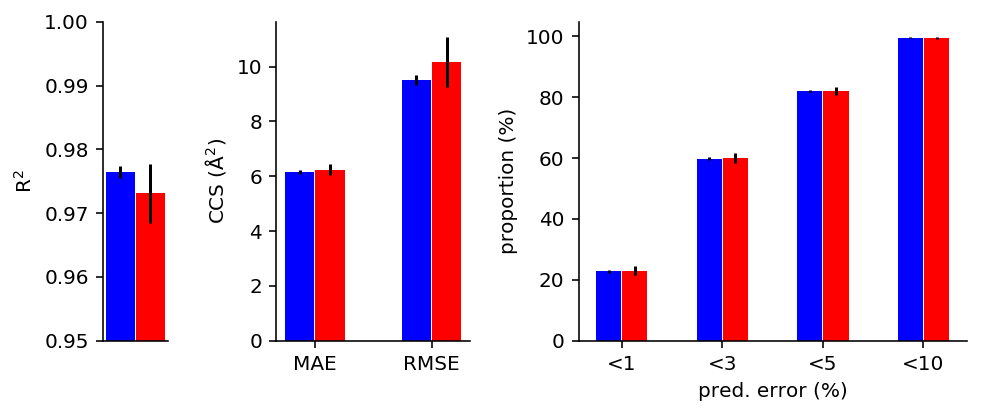

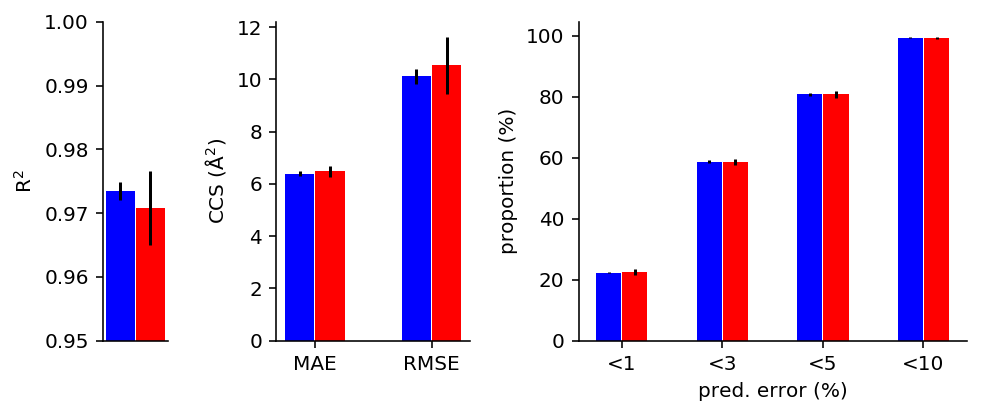

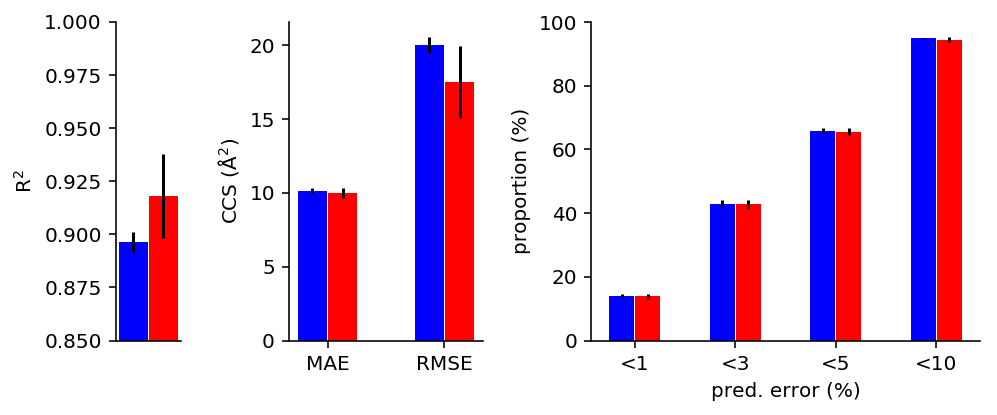

In [136]:
summary_figure(linear_all)
summary_figure(linear_sub)
summary_figure(linear_nomqn, r2_range=[0.85, 1.])

### SVR - all MDs _vs._ MD subset _vs._ no MQNs

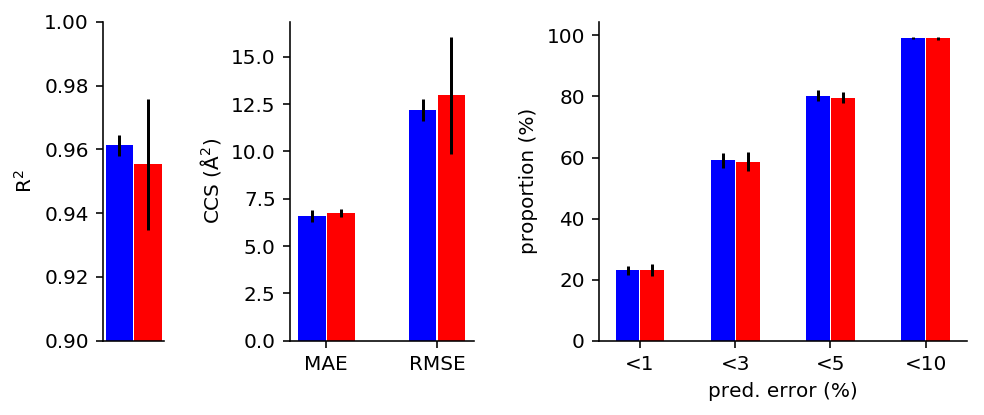

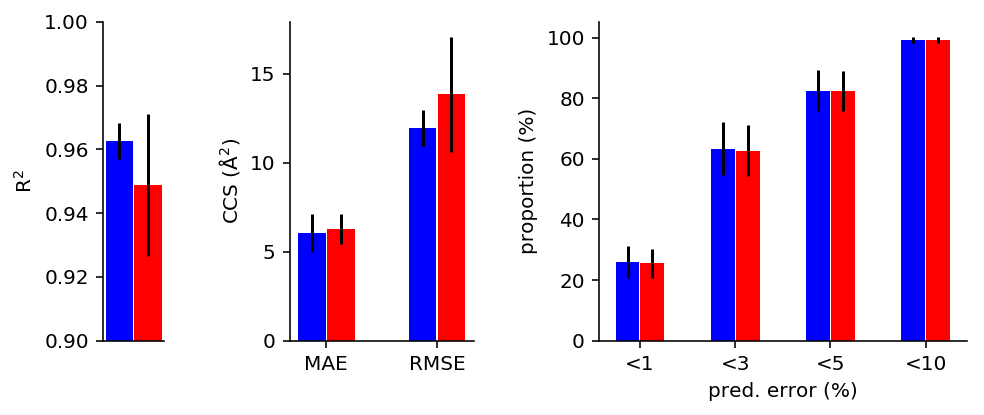

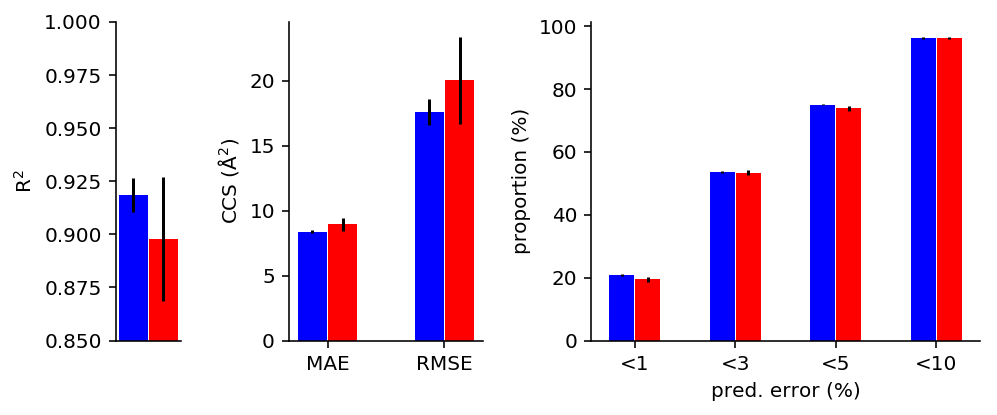

In [137]:
summary_figure(svr_all, r2_range=[0.9, 1.])
summary_figure(svr_sub, r2_range=[0.9, 1.])
summary_figure(svr_nomqn, r2_range=[0.85, 1.])

### RandomForestRegressor - all MDs _vs._ MD subset _vs._ no MQNs

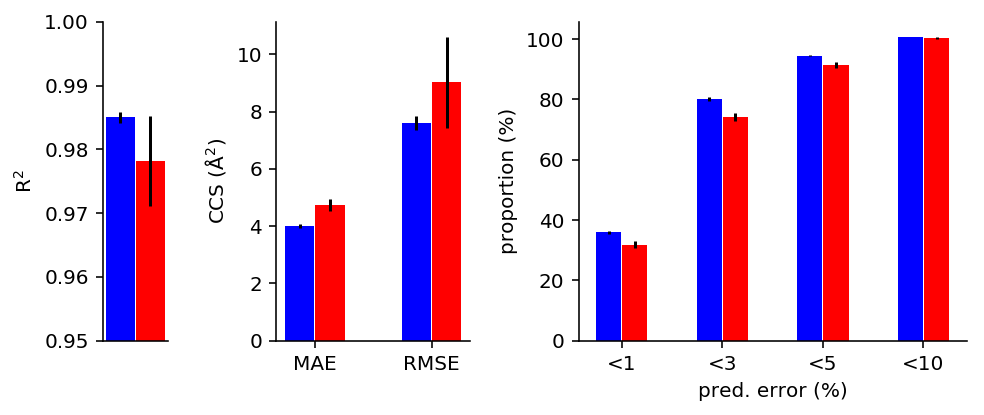

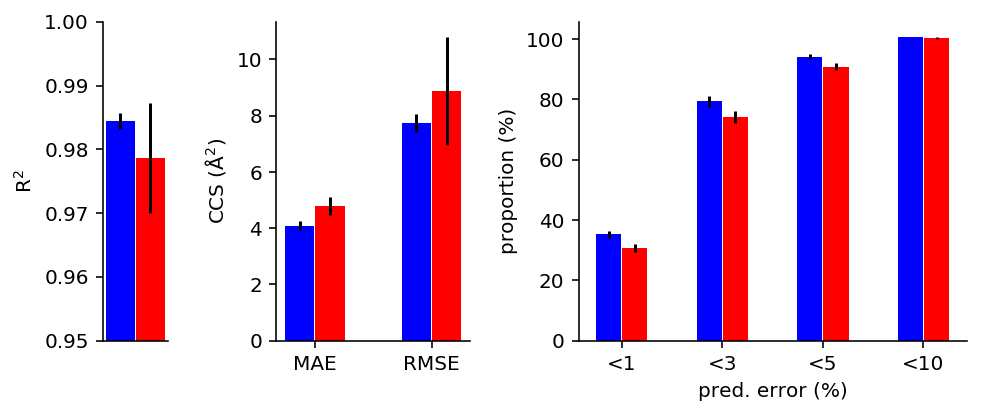

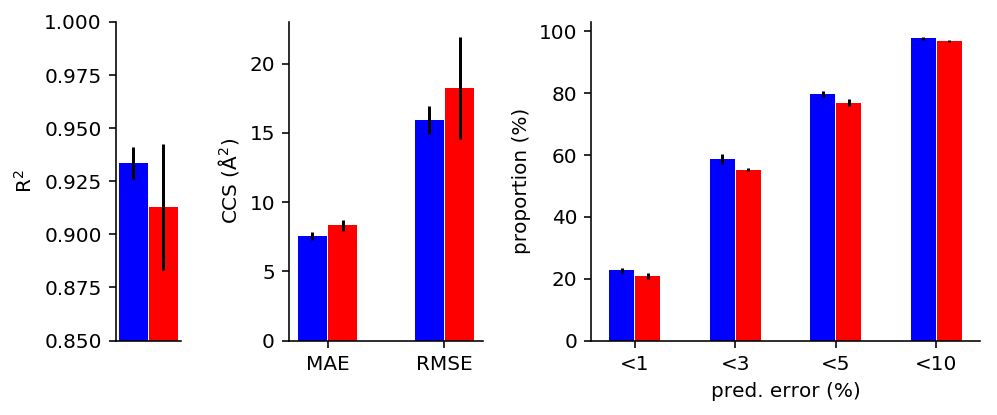

In [138]:
summary_figure(forest_all)
summary_figure(forest_sub)
summary_figure(forest_nomqn, r2_range=[0.85, 1.])

### Effect of Removing Encoded Adduct from the Features and Using only the MQN Subset

In [141]:
# perform 5 trials each
N = 5

# linear regression
print('\nlinear, no encoded adducrt')
linear_noadd = n_trials(LinearRegression(), mqn_subset, N, pRNGs)

# SVR with rbf kernel
pRNGs += N
svr_p_grid = {
    'C': [0.1, 0.3, 0.5, 1, 3, 5, 10],
    'gamma': [0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1]
}
print('\nSVR, no encoded adduct')
svr_noadd = n_trials(SVR(cache_size=1024, tol=5e-4), mqn_subset, N, pRNGs, p_grid=svr_p_grid)

# random forest
pRNGs += N
forest_p_grid = {
    'max_depth': [2, 4, 6, 8],
    'bootstrap': [True, False], 
    'min_samples_leaf': [0.256, 0.128, 0.064, 0.032, 0.016, 0.008, 0.004, 0.002, 0.001],
    'n_estimators': [8, 16, 32, 64, 128]
}
print('\nrandom forest, no encoded adduct')
forest_noadd = n_trials(RandomForestRegressor(), mqn_subset, N, pRNGs, p_grid=forest_p_grid)



linear, no encoded adducrt
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok

SVR, no encoded adduct
trial   1 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


ok
trial   2 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


ok
trial   3 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


ok
trial   4 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


ok
trial   5 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


ok

random forest, no encoded adduct
trial   1 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


ok
trial   2 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


ok
trial   3 of   5 ... ok
trial   4 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


ok
trial   5 of   5 ... ok


### LinearRegression - MD subset _vs._ MD subset without encoded adduct

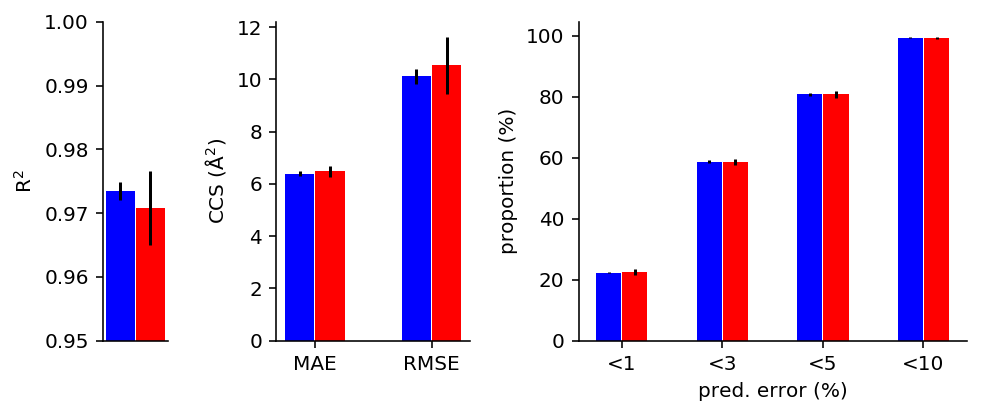

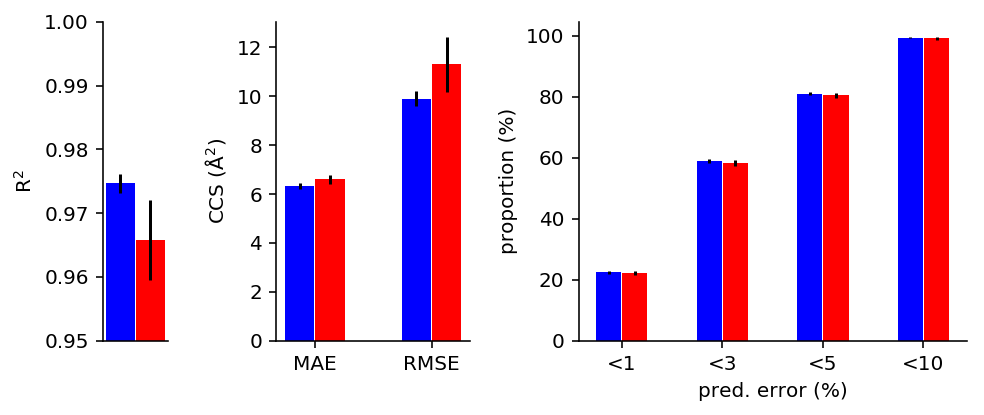

In [142]:
summary_figure(linear_sub)
summary_figure(linear_noadd)

### SVR - MD subset _vs._ MD subset without encoded adduct

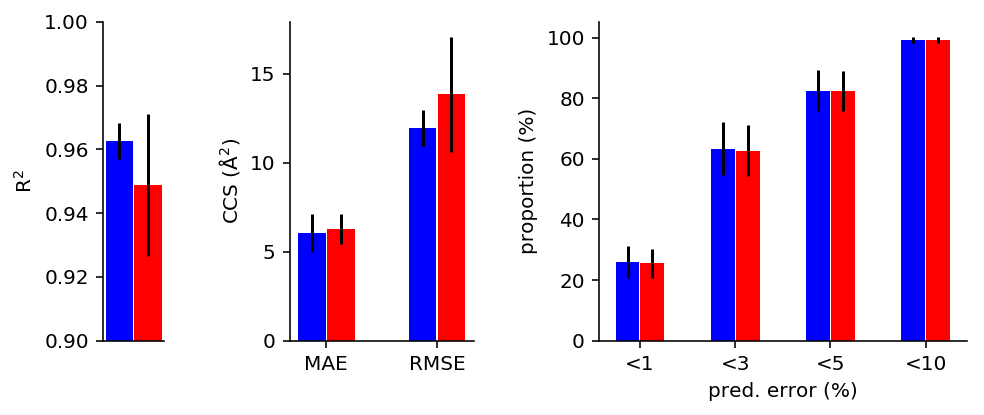

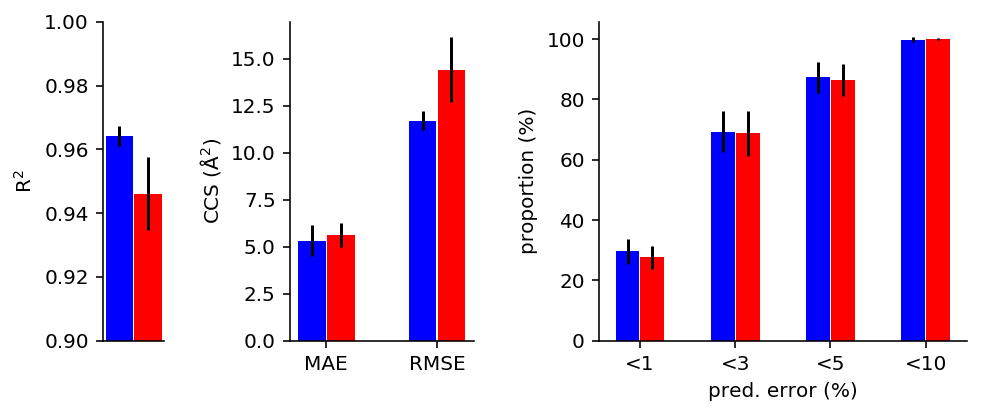

In [144]:
summary_figure(svr_sub, r2_range=[0.9, 1.])
summary_figure(svr_noadd, r2_range=[0.9, 1.])

### RandomForestRegressor - MD subset _vs._ MD subset without encoded adduct

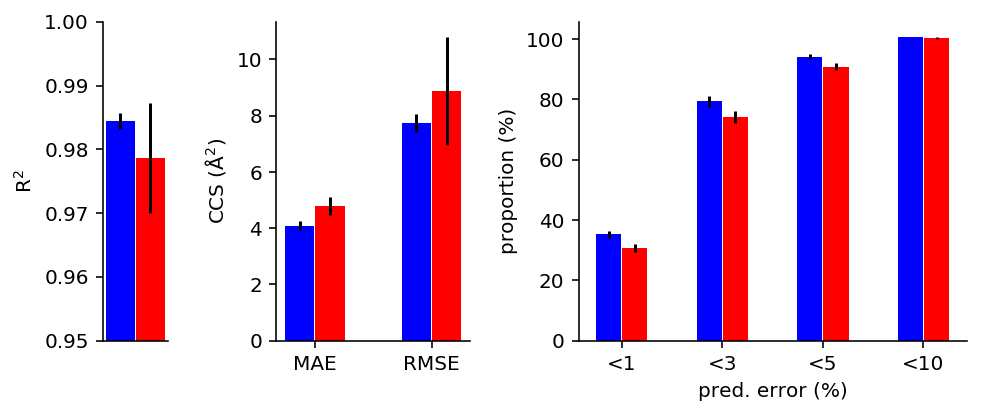

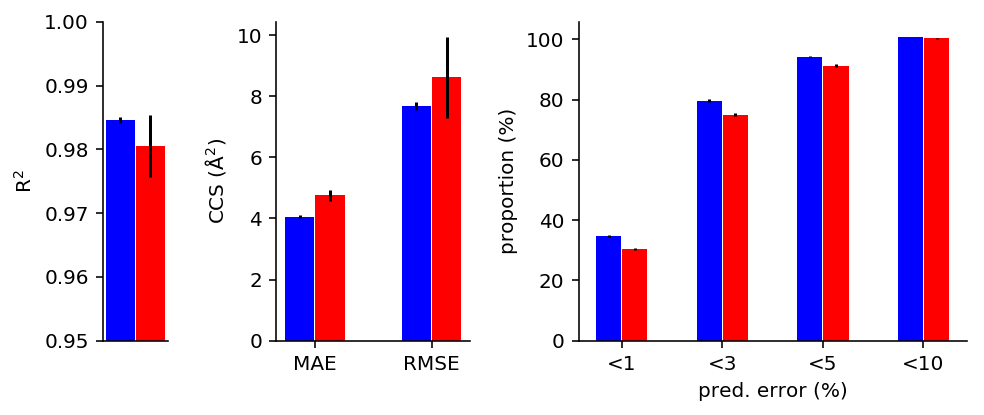

In [145]:
summary_figure(forest_sub)
summary_figure(forest_noadd)

In [146]:
from kmcm import KMCMulti, kmcm_p_grid


In [185]:
print('\nlasso, K-Means clustering')
kmcm_lasso_p_grid = kmcm_p_grid([3, 4, 5], {'alpha': [0.05, 0.1, 0.5]})
kmcm_lasso = n_trials(KMCMulti(seed=1239, use_estimator=Lasso(max_iter=10000)),
                       'all', 5, 1234, p_grid=kmcm_lasso_p_grid)



lasso, K-Means clustering
trial   1 of   5 ... best parameters: {'estimator_params': [{'alpha': 0.05}, {'alpha': 0.5}, {'alpha': 0.05}, {'alpha': 0.05}, {'alpha': 0.5}], 'n_clusters': 5}
ok
trial   2 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


best parameters: {'estimator_params': [{'alpha': 0.05}, {'alpha': 0.05}, {'alpha': 0.1}, {'alpha': 0.05}, {'alpha': 0.05}], 'n_clusters': 5}
ok
trial   3 of   5 ... best parameters: {'estimator_params': [{'alpha': 0.05}, {'alpha': 0.05}, {'alpha': 0.05}, {'alpha': 0.1}], 'n_clusters': 4}
ok
trial   4 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'estimator_params': [{'alpha': 0.05}, {'alpha': 0.1}, {'alpha': 0.05}, {'alpha': 0.1}, {'alpha': 0.05}], 'n_clusters': 5}
ok
trial   5 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


best parameters: {'estimator_params': [{'alpha': 0.05}, {'alpha': 0.05}, {'alpha': 0.05}, {'alpha': 0.5}], 'n_clusters': 4}
ok


In [186]:
print('\nlasso, all MDs')
lasso_all = n_trials(Lasso(max_iter=10000), 'all', 5, 1234, p_grid={'alpha': [0.01, 0.03, 0.05, 0.1, 0.3, 0.5]})


lasso, all MDs
trial   1 of   5 ... best parameters: {'alpha': 0.01}
ok
trial   2 of   5 ... best parameters: {'alpha': 0.01}
ok
trial   3 of   5 ... best parameters: {'alpha': 0.01}
ok
trial   4 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'alpha': 0.01}
ok
trial   5 of   5 ... best parameters: {'alpha': 0.01}
ok


### Lasso - all MDs - single model _vs._ KMCMulti

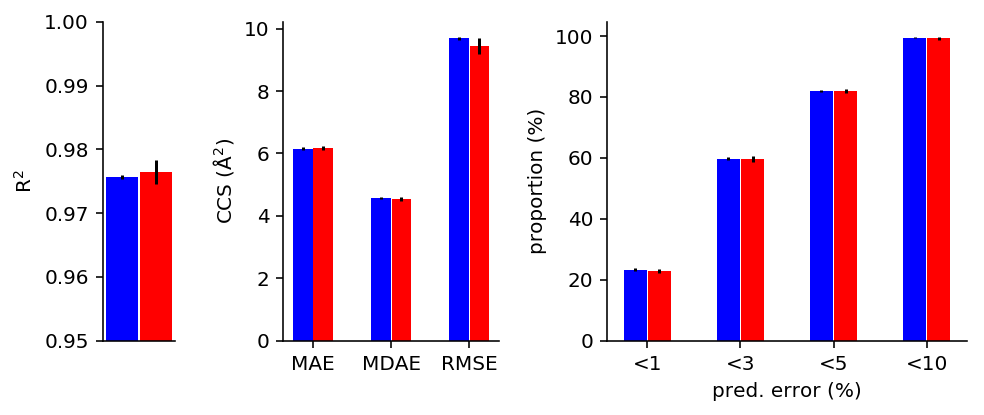

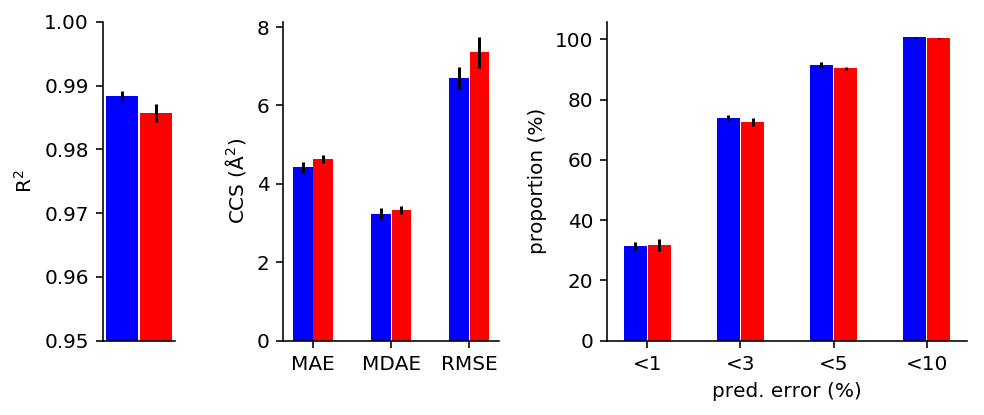

In [189]:
summary_figure(lasso_all)
summary_figure(kmcm_lasso)

In [190]:
# random forest
forest_p_grid = {
    'max_depth': [2, 4, 6, 8],
    'bootstrap': [True, False], 
    'min_samples_leaf': [0.256, 0.128, 0.064, 0.032, 0.016, 0.008, 0.004, 0.002, 0.001],
    'n_estimators': [8, 16, 32, 64, 128]
}
print('\nrandom forest, all MDs')
forest_all = n_trials(RandomForestRegressor(), 'all', 5, 1240, p_grid=forest_p_grid)



random forest, all MDs
trial   1 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'bootstrap': True, 'max_depth': 8, 'min_samples_leaf': 0.001, 'n_estimators': 16}
ok
trial   2 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'bootstrap': True, 'max_depth': 8, 'min_samples_leaf': 0.001, 'n_estimators': 128}
ok
trial   3 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'bootstrap': True, 'max_depth': 8, 'min_samples_leaf': 0.001, 'n_estimators': 16}
ok
trial   4 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'bootstrap': True, 'max_depth': 8, 'min_samples_leaf': 0.001, 'n_estimators': 128}
ok
trial   5 of   5 ... best parameters: {'bootstrap': True, 'max_depth': 8, 'min_samples_leaf': 0.001, 'n_estimators': 128}
ok


In [ ]:
print('\nRandomForestRegressor, K-Means clustering')
kmcm_forest_p_grid = kmcm_p_grid([3, 4], {'n_estimators': [2, 4, 8], 'min_samples_leaf': [0.01, 0.05]})
kmcm_forest = n_trials(KMCMulti(seed=1241, use_estimator=RandomForestRegressor(bootstrap=True)),
                       'all', 5, 1241, p_grid=kmcm_forest_p_grid)


RandomForestRegressor, K-Means clustering
trial   1 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'estimator_params': [{'n_estimators': 4, 'min_samples_leaf': 0.01}, {'n_estimators': 4, 'min_samples_leaf': 0.01}, {'n_estimators': 2, 'min_samples_leaf': 0.01}, {'n_estimators': 4, 'min_samples_leaf': 0.01}], 'n_clusters': 4}
ok
trial   2 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'estimator_params': [{'n_estimators': 8, 'min_samples_leaf': 0.01}, {'n_estimators': 4, 'min_samples_leaf': 0.01}, {'n_estimators': 8, 'min_samples_leaf': 0.01}, {'n_estimators': 2, 'min_samples_leaf': 0.01}], 'n_clusters': 4}
ok
trial   3 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'estimator_params': [{'n_estimators': 4, 'min_samples_leaf': 0.01}, {'n_estimators': 8, 'min_samples_leaf': 0.01}, {'n_estimators': 4, 'min_samples_leaf': 0.01}], 'n_clusters': 3}
ok
trial   4 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'estimator_params': [{'n_estimators': 8, 'min_samples_leaf': 0.01}, {'n_estimators': 8, 'min_samples_leaf': 0.01}, {'n_estimators': 8, 'min_samples_leaf': 0.01}, {'n_estimators': 2, 'min_samples_leaf': 0.01}], 'n_clusters': 4}
ok
trial   5 of   5 ... 

# Trials with Full and Reduced Feature Sets

In [282]:
# minimal MD subset
min_sub = [11, 12, 0, 9, 18, 25, 19, 20, 26, 13]

print('\nlinear_regression, feature selection trials')
linear_all = n_trials(LinearRegression(), 'all', 5, 1260)
linear_fs = n_trials(LinearRegression(), fsel_keepers, 5, 1265)
linear_min = n_trials(LinearRegression(), min_sub, 5, 1270)


linear_regression, feature selection trials
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok


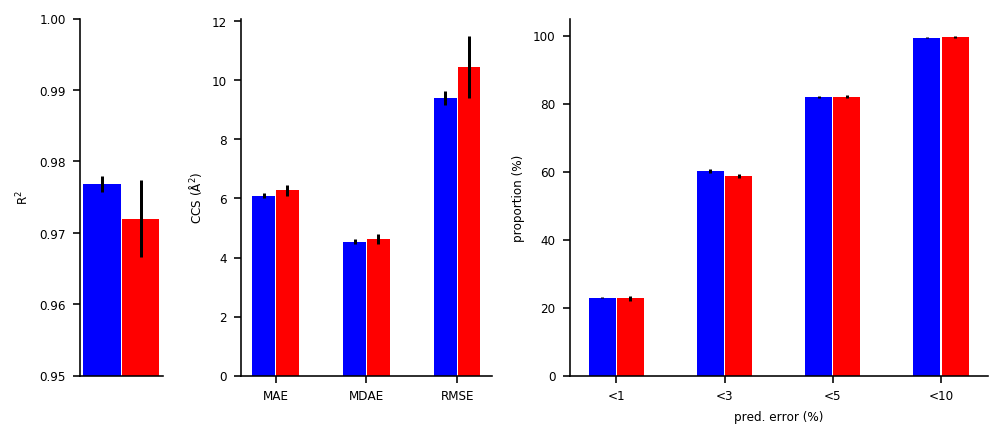

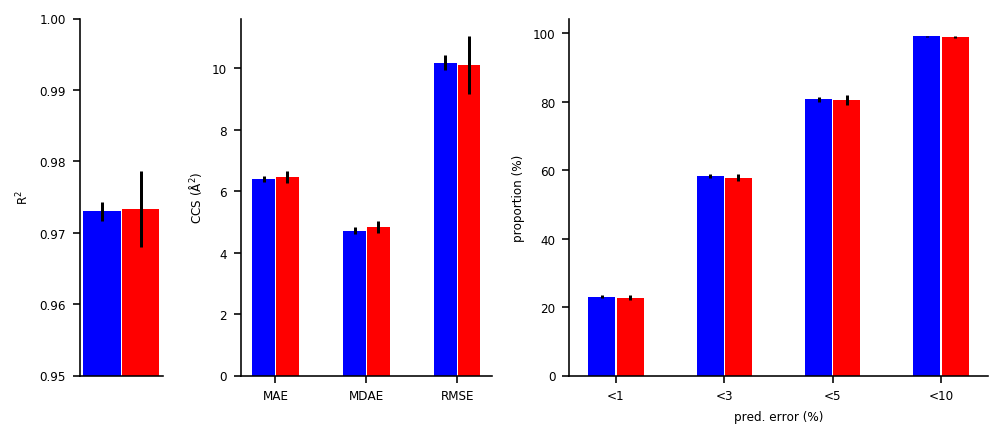

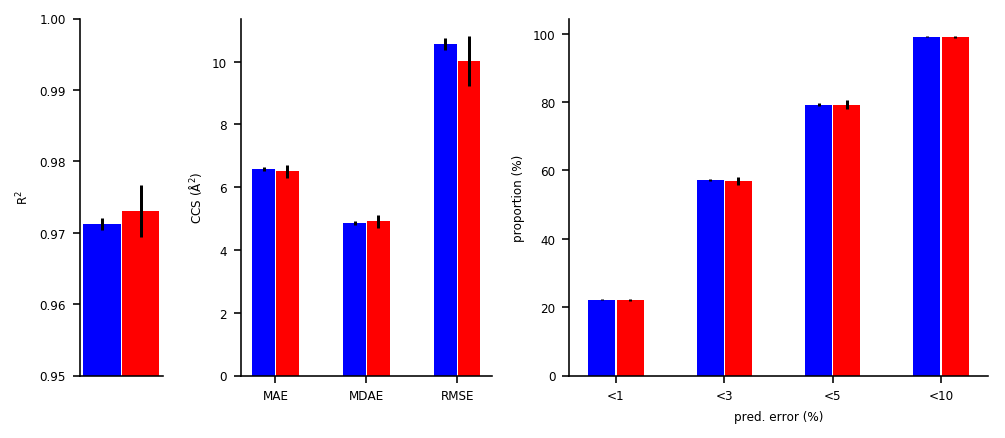

In [283]:
summary_figure(linear_all)
summary_figure(linear_fs)
summary_figure(linear_min)

In [284]:
print('\nlasso, minimal MDs')
lasso_all= n_trials(Lasso(max_iter=10000), 'all', 5, 1275, p_grid={'alpha': [0.01, 0.03, 0.05, 0.1, 0.3, 0.5]})
lasso_fs = n_trials(Lasso(max_iter=10000), fsel_keepers, 5, 1280, p_grid={'alpha': [0.01, 0.03, 0.05, 0.1, 0.3, 0.5]})
lasso_min = n_trials(Lasso(max_iter=10000), min_sub, 5, 1285, p_grid={'alpha': [0.01, 0.03, 0.05, 0.1, 0.3, 0.5]})


lasso, minimal MDs
trial   1 of   5 ... best parameters: {'alpha': 0.01}
ok
trial   2 of   5 ... best parameters: {'alpha': 0.01}
ok
trial   3 of   5 ... best parameters: {'alpha': 0.01}
ok
trial   4 of   5 ... best parameters: {'alpha': 0.01}
ok
trial   5 of   5 ... best parameters: {'alpha': 0.01}
ok
trial   1 of   5 ... best parameters: {'alpha': 0.01}
ok
trial   2 of   5 ... best parameters: {'alpha': 0.01}
ok
trial   3 of   5 ... best parameters: {'alpha': 0.01}
ok
trial   4 of   5 ... best parameters: {'alpha': 0.01}
ok
trial   5 of   5 ... best parameters: {'alpha': 0.01}
ok
trial   1 of   5 ... best parameters: {'alpha': 0.01}
ok
trial   2 of   5 ... best parameters: {'alpha': 0.01}
ok
trial   3 of   5 ... best parameters: {'alpha': 0.01}
ok
trial   4 of   5 ... best parameters: {'alpha': 0.01}
ok
trial   5 of   5 ... best parameters: {'alpha': 0.01}
ok


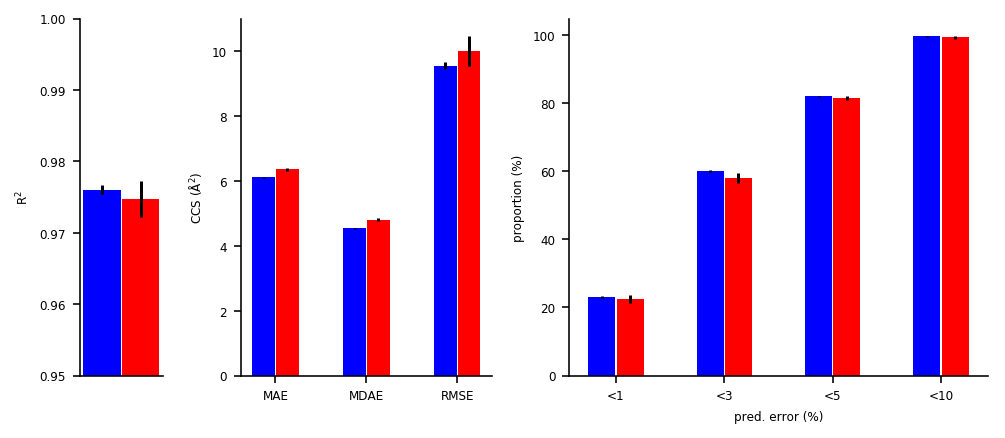

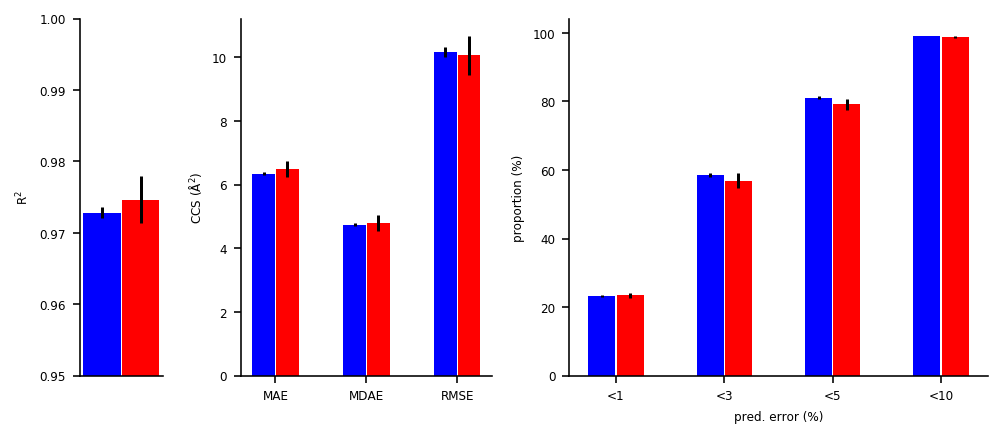

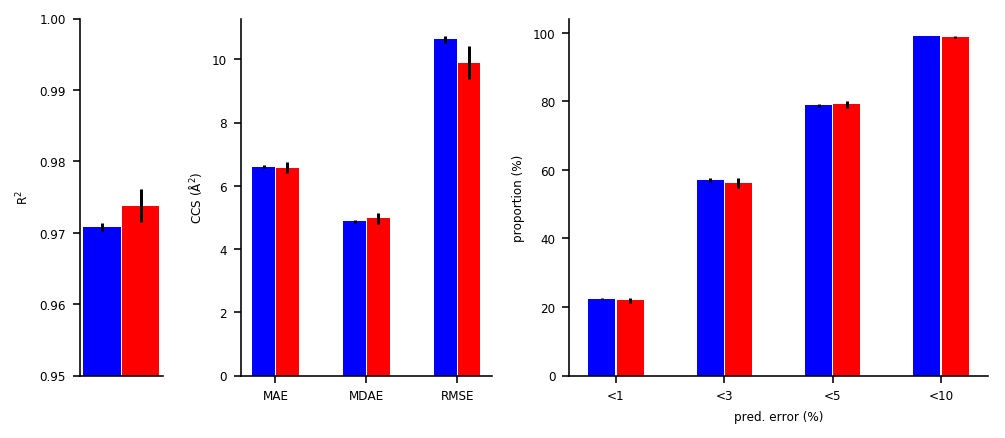

In [285]:
summary_figure(lasso_all)
summary_figure(lasso_fs)
summary_figure(lasso_min)

In [286]:
print('\nrandom_forest_regressor, feature selection trials')
forest_p_grid = {
    'max_depth': [4, 8, 16],
    'bootstrap': [True, False], 
    'min_samples_leaf': [0.064, 0.032, 0.016, 0.008, 0.004],
    'n_estimators': [4, 8, 16, 32, 64]
}
forest_all = n_trials(RandomForestRegressor(), 'all', 5, 1290, p_grid=forest_p_grid)
forest_fs = n_trials(RandomForestRegressor(), fsel_keepers, 5, 1295, p_grid=forest_p_grid)
forest_min = n_trials(RandomForestRegressor(), min_sub, 5, 1300, p_grid=forest_p_grid)



random_forest_regressor, feature selection trials
trial   1 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'bootstrap': True, 'max_depth': 8, 'min_samples_leaf': 0.004, 'n_estimators': 8}
ok
trial   2 of   5 ... best parameters: {'bootstrap': True, 'max_depth': 16, 'min_samples_leaf': 0.004, 'n_estimators': 16}
ok
trial   3 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'bootstrap': True, 'max_depth': 16, 'min_samples_leaf': 0.004, 'n_estimators': 64}
ok
trial   4 of   5 ... best parameters: {'bootstrap': True, 'max_depth': 16, 'min_samples_leaf': 0.004, 'n_estimators': 8}
ok
trial   5 of   5 ... best parameters: {'bootstrap': True, 'max_depth': 16, 'min_samples_leaf': 0.004, 'n_estimators': 32}
ok
trial   1 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'bootstrap': True, 'max_depth': 16, 'min_samples_leaf': 0.004, 'n_estimators': 64}
ok
trial   2 of   5 ... best parameters: {'bootstrap': True, 'max_depth': 8, 'min_samples_leaf': 0.004, 'n_estimators': 8}
ok
trial   3 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'bootstrap': True, 'max_depth': 16, 'min_samples_leaf': 0.004, 'n_estimators': 64}
ok
trial   4 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'bootstrap': True, 'max_depth': 16, 'min_samples_leaf': 0.004, 'n_estimators': 32}
ok
trial   5 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'bootstrap': True, 'max_depth': 16, 'min_samples_leaf': 0.004, 'n_estimators': 32}
ok
trial   1 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'bootstrap': True, 'max_depth': 16, 'min_samples_leaf': 0.004, 'n_estimators': 64}
ok
trial   2 of   5 ... best parameters: {'bootstrap': True, 'max_depth': 16, 'min_samples_leaf': 0.004, 'n_estimators': 16}
ok
trial   3 of   5 ... best parameters: {'bootstrap': True, 'max_depth': 16, 'min_samples_leaf': 0.004, 'n_estimators': 64}
ok
trial   4 of   5 ... best parameters: {'bootstrap': True, 'max_depth': 16, 'min_samples_leaf': 0.004, 'n_estimators': 64}
ok
trial   5 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'bootstrap': True, 'max_depth': 16, 'min_samples_leaf': 0.004, 'n_estimators': 32}
ok


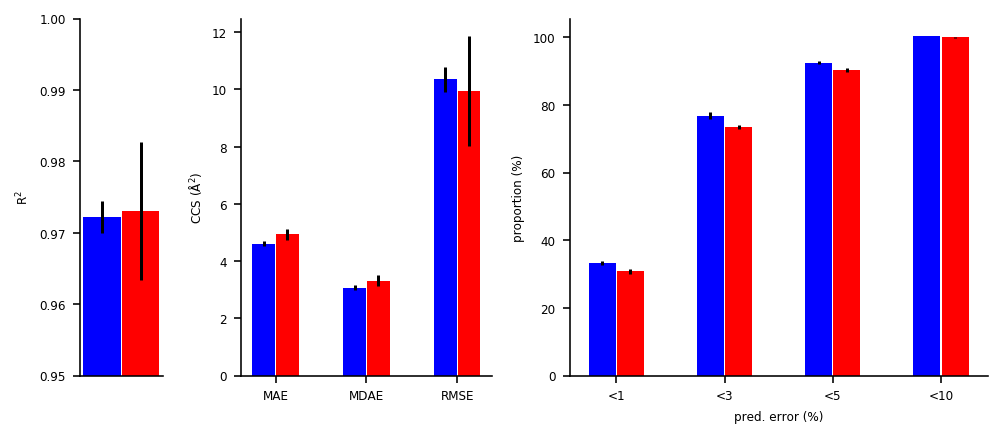

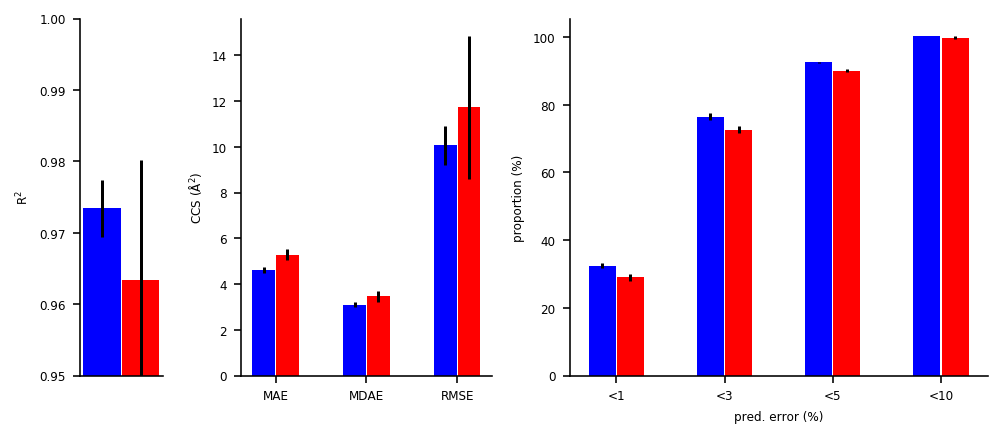

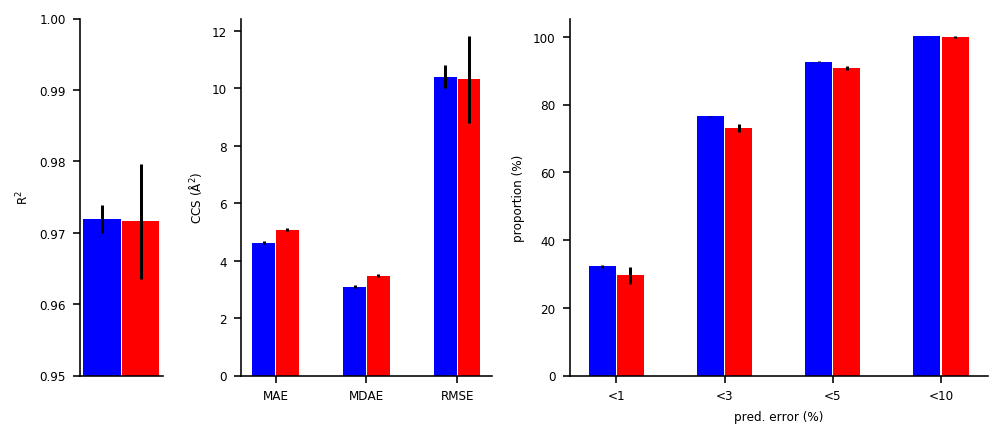

In [287]:
summary_figure(forest_all)
summary_figure(forest_fs)
summary_figure(forest_min)

In [295]:
print('SVR, feature selection trials')
svr_p_grid = {
    'C': [100, 300, 500, 1000, 3000, 5000],
    'gamma': [0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05]
}
svr_all = n_trials(SVR(cache_size=1024, tol=1e-3), 'all', 5, 1305, p_grid=svr_p_grid)
svr_fs = n_trials(SVR(cache_size=1024, tol=1e-3), fsel_keepers, 5, 1310, p_grid=svr_p_grid)
svr_min = n_trials(SVR(cache_size=1024, tol=1e-3), min_sub, 5, 1315, p_grid=svr_p_grid)

SVR, feature selection trials
trial   1 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'C': 5000, 'gamma': 0.0005}
ok
trial   2 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'C': 5000, 'gamma': 0.0005}
ok
trial   3 of   5 ... best parameters: {'C': 5000, 'gamma': 0.001}
ok
trial   4 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'C': 5000, 'gamma': 0.001}
ok
trial   5 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'C': 5000, 'gamma': 0.0005}
ok
trial   1 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'C': 5000, 'gamma': 0.01}
ok
trial   2 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'C': 5000, 'gamma': 0.01}
ok
trial   3 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'C': 3000, 'gamma': 0.03}
ok
trial   4 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'C': 5000, 'gamma': 0.01}
ok
trial   5 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'C': 5000, 'gamma': 0.01}
ok
trial   1 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'C': 5000, 'gamma': 0.01}
ok
trial   2 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'C': 3000, 'gamma': 0.03}
ok
trial   3 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'C': 5000, 'gamma': 0.01}
ok
trial   4 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'C': 5000, 'gamma': 0.01}
ok
trial   5 of   5 ... best parameters: {'C': 3000, 'gamma': 0.03}
ok


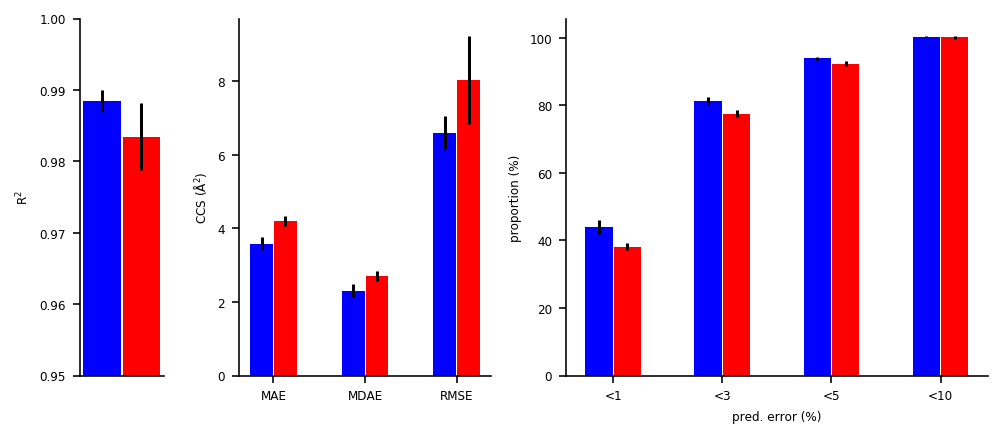

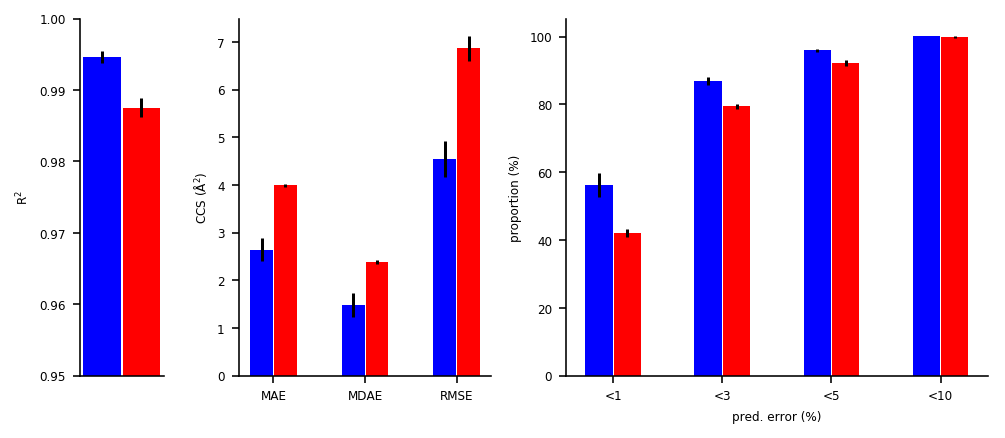

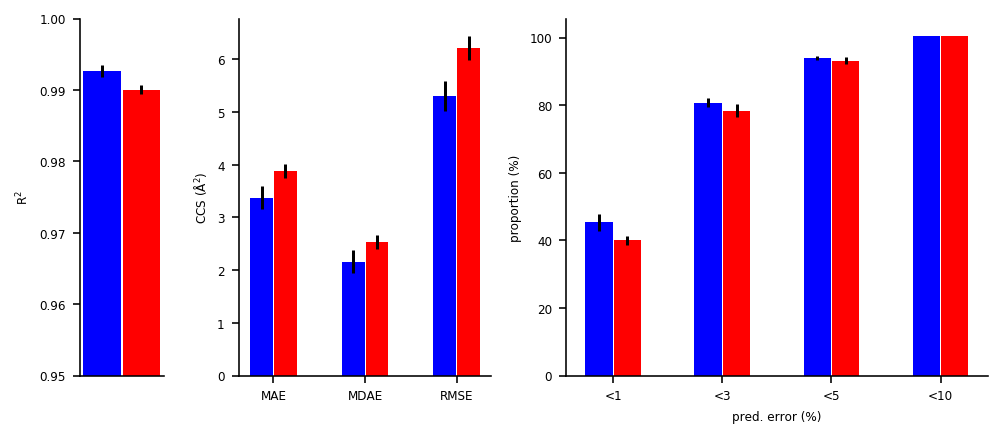

In [296]:
summary_figure(svr_all)
summary_figure(svr_fs)
summary_figure(svr_min)

In [297]:
# dump trial results to disk 
import json


mdl_fs_dicts = {
    'linear': {
        'all': linear_all,
        'fs': linear_fs,
        'min': linear_min,
    },
    'lasso': {
        'all': lasso_all,
        'fs': lasso_fs,
        'min': lasso_min,
    },
    'forest': {
        'all': forest_all,
        'fs': forest_fs,
        'min': forest_min,
    },
    'svr': {
        'all': svr_all,
        'fs': svr_fs,
        'min': svr_min,
    }
}

for mdl in ['linear', 'lasso', 'forest', 'svr']:
    for fs in ['all', 'fs', 'min']:
        with open('{}_{}_results.json'.format(mdl, fs), 'w') as j:
            json.dump(mdl_fs_dicts[mdl][fs], j, indent=4)


In [318]:
print('\nlinear, K-Means clustering')
kmcm_linear = n_trials(KMCMulti(n_clusters=4, 
                                seed=1550, 
                                use_estimator=LinearRegression(), 
                                estimator_params=[{}, {}, {}, {}]), 'all', 5, 1250)


linear, K-Means clustering
trial   1 of   5 ... ok
trial   2 of   5 ... ok
trial   3 of   5 ... ok
trial   4 of   5 ... ok
trial   5 of   5 ... ok


In [319]:
kmcm_linear

[{'train': {'R2': 0.9884672477645471,
   'MAE': 4.4217078859610055,
   'MDAE': 3.2821855566862155,
   'RMSE': 6.6803460153841865,
   'CE135A': [0.3152405633422669,
    0.7378105224980548,
    0.9183094671274732,
    1.0064503069114648]},
  'test': {'R2': -3.692954872954256e+21,
   'MAE': 151638471163.67523,
   'MDAE': 3.056013681686238,
   'RMSE': 3725166287311.2944,
   'CE135A': [0.3412738638283494,
    0.7501267105930056,
    0.9182294306470687,
    1.009461057611083]}},
 {'train': {'R2': 0.9890764589039125,
   'MAE': 4.283623439603182,
   'MDAE': 3.151599450096171,
   'RMSE': 6.491708122588378,
   'CE135A': [0.32561962569549824,
    0.7458691620300119,
    0.9224835609509358,
    1.0063648625864103]},
  'test': {'R2': -7.310704546190363e+18,
   'MAE': 6765125303.573625,
   'MDAE': 3.0249999999999773,
   'RMSE': 166785431925.14688,
   'CE135A': [0.35970615553491514,
    0.7481212530608798,
    0.9161530017731994,
    1.0005910664527569]}},
 {'train': {'R2': 0.9887066991364333,
   'MA

In [320]:
print('\nlasso, K-Means clustering')
kmcm_lasso_p_grid = kmcm_p_grid([4], {'alpha': [0.01, 0.05, 0.1]})
kmcm_lasso = n_trials(KMCMulti(seed=1260, use_estimator=Lasso(max_iter=20000)),
                      'all', 5, 1234, p_grid=kmcm_lasso_p_grid)


lasso, K-Means clustering
trial   1 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/dilly/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


best parameters: {'estimator_params': [{'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 0.01}, {'alpha': 0.01}], 'n_clusters': 4}
ok
trial   2 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


best parameters: {'estimator_params': [{'alpha': 0.01}, {'alpha': 0.01}, {'alpha': 0.01}, {'alpha': 0.01}], 'n_clusters': 4}
ok
trial   3 of   5 ... best parameters: {'estimator_params': [{'alpha': 0.01}, {'alpha': 0.1}, {'alpha': 0.05}, {'alpha': 0.01}], 'n_clusters': 4}
ok
trial   4 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'estimator_params': [{'alpha': 0.1}, {'alpha': 0.01}, {'alpha': 0.01}, {'alpha': 0.1}], 'n_clusters': 4}
ok
trial   5 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


best parameters: {'estimator_params': [{'alpha': 0.01}, {'alpha': 0.01}, {'alpha': 0.01}, {'alpha': 0.01}], 'n_clusters': 4}
ok


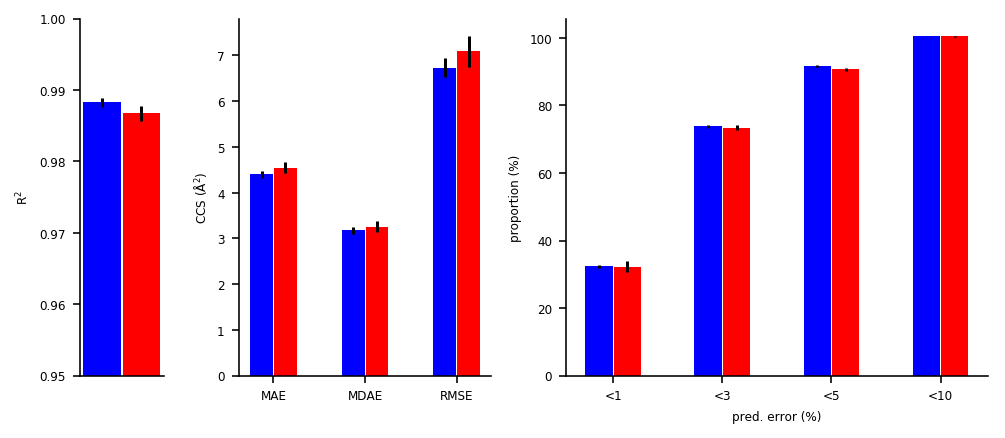

In [321]:
summary_figure(kmcm_lasso)

In [322]:
print('\nRandomForestRegressor, K-Means clustering')
kmcm_forest_p_grid = kmcm_p_grid([4], {'n_estimators': [4, 8, 16, 32]})
kmcm_forest = n_trials(KMCMulti(seed=1241, use_estimator=RandomForestRegressor(bootstrap=True, min_samples_leaf=0.01)),
                       'all', 5, 1265, p_grid=kmcm_forest_p_grid)



RandomForestRegressor, K-Means clustering
trial   1 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'estimator_params': [{'n_estimators': 32}, {'n_estimators': 16}, {'n_estimators': 16}, {'n_estimators': 4}], 'n_clusters': 4}
ok
trial   2 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'estimator_params': [{'n_estimators': 8}, {'n_estimators': 4}, {'n_estimators': 4}, {'n_estimators': 32}], 'n_clusters': 4}
ok
trial   3 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'estimator_params': [{'n_estimators': 16}, {'n_estimators': 16}, {'n_estimators': 32}, {'n_estimators': 4}], 'n_clusters': 4}
ok
trial   4 of   5 ... best parameters: {'estimator_params': [{'n_estimators': 16}, {'n_estimators': 8}, {'n_estimators': 16}, {'n_estimators': 8}], 'n_clusters': 4}
ok
trial   5 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'estimator_params': [{'n_estimators': 32}, {'n_estimators': 16}, {'n_estimators': 8}, {'n_estimators': 8}], 'n_clusters': 4}
ok


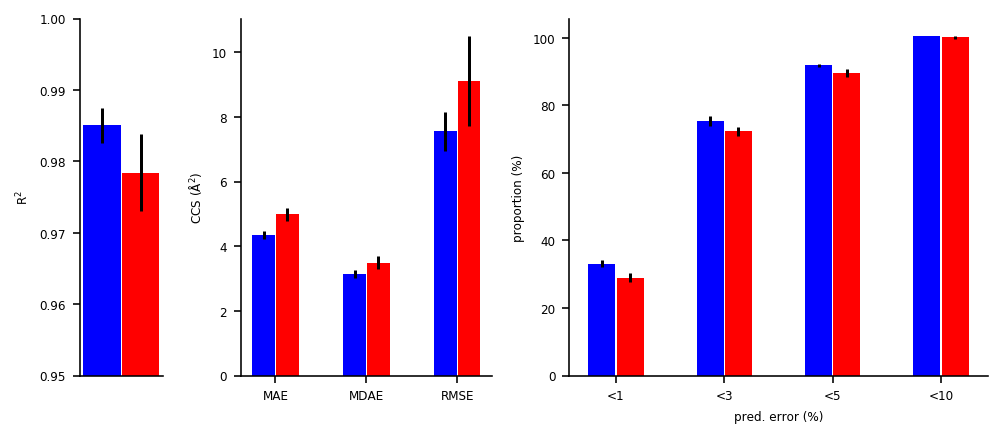

In [323]:
summary_figure(kmcm_forest)

In [326]:
kmcm_svr_p_grid = kmcm_p_grid([4], {'C': [2000, 8000], 'gamma': [0.001, 0.05]})
kmcm_svr = n_trials(KMCMulti(seed=1360, use_estimator=SVR(cache_size=1024, tol=1e-3)),
                       'all', 5, 1265, p_grid=kmcm_svr_p_grid)

trial   1 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'estimator_params': [{'C': 8000, 'gamma': 0.001}, {'C': 2000, 'gamma': 0.001}, {'C': 2000, 'gamma': 0.001}, {'C': 8000, 'gamma': 0.001}], 'n_clusters': 4}
ok
trial   2 of   5 ... best parameters: {'estimator_params': [{'C': 8000, 'gamma': 0.001}, {'C': 8000, 'gamma': 0.001}, {'C': 8000, 'gamma': 0.001}, {'C': 8000, 'gamma': 0.001}], 'n_clusters': 4}
ok
trial   3 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'estimator_params': [{'C': 8000, 'gamma': 0.001}, {'C': 8000, 'gamma': 0.001}, {'C': 8000, 'gamma': 0.001}, {'C': 8000, 'gamma': 0.001}], 'n_clusters': 4}
ok
trial   4 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'estimator_params': [{'C': 8000, 'gamma': 0.001}, {'C': 8000, 'gamma': 0.001}, {'C': 2000, 'gamma': 0.001}, {'C': 8000, 'gamma': 0.001}], 'n_clusters': 4}
ok
trial   5 of   5 ... 

/home/dilly/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:803: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'estimator_params': [{'C': 8000, 'gamma': 0.001}, {'C': 2000, 'gamma': 0.001}, {'C': 8000, 'gamma': 0.001}, {'C': 8000, 'gamma': 0.001}], 'n_clusters': 4}
ok


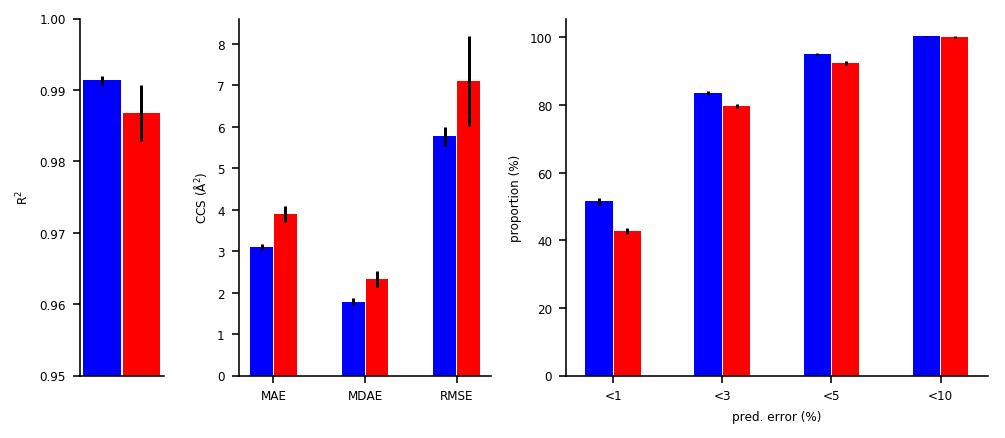

In [327]:
summary_figure(kmcm_svr)

In [328]:
# dump kmcm performance stats to disk
for d, mdl in zip([kmcm_lasso, kmcm_forest, kmcm_svr], ['lasso', 'forest', 'svr']):
    with open('kmcm_{}_results.json'.format(mdl), 'w') as j:
            json.dump(d, j, indent=4)